In [1]:
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from dotenv import load_dotenv
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import FAISS
from langchain_core.tools import tool
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, Annotated
from langgraph.graph.message import add_messages
from langchain_core.messages import HumanMessage, BaseMessage
from langgraph.prebuilt import ToolNode, tools_condition

In [2]:
load_dotenv()

True

In [3]:
llm = ChatOpenAI(model="gpt-4o-mini")

In [4]:
loader = PyPDFLoader('intro-to-ml.pdf')
docs = loader.load()
len(docs)

392

In [5]:
splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
chunks = splitter.split_documents(docs)
len(chunks)

973

In [6]:
embeddings = OpenAIEmbeddings(model="text-embedding-3-small")
vector_store = FAISS.from_documents(chunks, embeddings)

In [7]:
vector_store

In [8]:
retriever = vector_store.as_retriever(
    search_tupe="similiarity", search_kwargs={"k": 4})

In [9]:
retriever.invoke("What is the Decision tree?")[0]

Document(id='6f0e7cf1-f401-4282-bae6-64a74e79f17c', metadata={'producer': '3-Heights(TM) PDF Optimization Shell 5.9.1.5 (http://www.pdf-tools.com)', 'creator': 'AH CSS Formatter V6.2 MR4 for Linux64 : 6.2.6.18551 (2014/09/24 15:00JST)', 'creationdate': '2016-09-21T13:04:39+00:00', 'author': 'Andreas C. Müller and Sarah Guido', 'title': 'Introduction to Machine Learning with Python', 'trapped': '/False', 'moddate': '2020-08-19T07:09:16+02:00', 'source': 'intro-to-ml.pdf', 'total_pages': 392, 'page': 86, 'page_label': '73'}, page_content='Figure 2-24. Decision boundary of tree with depth 1 (left) and corresponding tree (right)\nFigure 2-25. Decision boundary of tree with depth 2 (left) and corresponding decision\ntree (right)\nThis recursive process yields a binary tree of decisions, with each node containing a\ntest. Alternatively, you can think of each test as splitting the part of the data that is\ncurrently being considered along one axis. This yields a view of the algorithm as\nbui

In [11]:
@tool
def rag_tool(query):
    """
    Retrieve relevant information from the pdf docuemnt.
    use this tool when the user asks factual / conceptual questions
    that might be answered from the stored documents.
    """
    result = retriever.invoke(query)
    context = [doc.page_content for doc in result]
    metadata = [doc.metadata for doc in result]
    return {
        'query': query,
        'context': context,
        'metadata': metadata
    }

In [12]:
tools=[rag_tool]
llm_with_tool=llm.bind_tools(tools)

In [13]:
class ChatState(TypedDict):
    messages:Annotated[list[BaseMessage],add_messages]

In [14]:
def chat_node(state:ChatState):
    messages=state['messages']
    response=llm_with_tool.invoke(messages)
    return {'messages':[response]}

In [15]:
tool_node=ToolNode(tools)

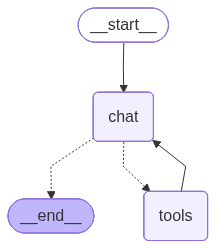

In [18]:
graph=StateGraph(ChatState)
graph.add_node("chat", chat_node)
graph.add_node('tools',tool_node)

graph.add_edge(START,'chat')
graph.add_conditional_edges(
    'chat',
    tools_condition
)
graph.add_edge('tools','chat')
graph.add_edge('chat',END)

chatbot=graph.compile()
chatbot

In [19]:
result=chatbot.invoke({
    'messages':[HumanMessage(content="What is decision tree?")]
})

In [22]:
result['messages'][-1].content

'A decision tree is a model used in machine learning and statistics to make decisions based on a series of questions leading to a conclusion or prediction. Here are some key aspects of decision trees:\n\n1. **Structure**: A decision tree consists of nodes, where each node represents a feature or attribute to be tested. The branches represent the outcomes of the tests, leading to further nodes or terminal nodes (also known as leaves) that contain the final output or decision.\n\n2. **Recursive Partitioning**: The process of building a decision tree involves recursively splitting the data based on feature tests, forming a hierarchical partition. At each node, the data is divided along one axis, creating axis-parallel boundaries in the feature space.\n\n3. **Making Predictions**: Predictions for new data points are made by traversing the tree from the root to the leaves based on the outcomes of the tests. The output corresponds to the majority target value in that region or the single tar